# Predict vehicle color from image
This notebook is used to train and evaluate color models trained on various datasets


## Colab specific
- Install additional libraries
- Setup integration with google drive
    - Needs these paths: mount point, Dataset storage path, checkpoint storage path, prediction storage path
- Setup content folder as git repo and pull codebase from github
    - For now we can manually set it up by using a [PAT](https://docs.github.com/en/github/authenticating-to-github/keeping-your-account-and-data-secure/creating-a-personal-access-token). We read this PAT from a location on google drive
    - This can be also done by installing github cli and triggering authentication on browser, cleaner workflow when multiple users use this notebook(TBD). 


In [1]:
%%capture
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts
! pip install ipywidgets
! pip install torchmetrics
! pip install efficientnet_pytorch

### The project expects a few folders in the root directory. Since the colab environment is transient, these folders need to be recreated everytime a fresh runtime is started. The below cell creates links to the source folder present in google drive:
- checkpoints  (For storing logs and model checkpoints)
- predictions (For storing the predictions while evaluating)
- carzam (For downloading the compressed dataset files, used in the setup_dataset method)
- dataset (NOT CREATED HERE, Running setup_dataset method creates this folder and copies the extracted dataset files)

In [2]:
import os
# Path constants
STORAGE_ROOT='/content/drive'
CARZAM_ROOT= os.path.join(STORAGE_ROOT, 'MyDrive/Gatech/CARZAM')
CHECKPOINT_ROOT=os.path.join(CARZAM_ROOT, 'checkpoints')
PREDICTION_ROOT=os.path.join(CARZAM_ROOT, 'predictions')
DATASET_ROOT=os.path.join(CARZAM_ROOT, 'Datasets')
COMPCAR_ROOT=os.path.join(CARZAM_ROOT, 'CompCars')

In [3]:
from google.colab import drive
drive.mount(STORAGE_ROOT)
!mkdir -p "{CHECKPOINT_ROOT}"
!mkdir -p "{PREDICTION_ROOT}"
!ln -s "{CHECKPOINT_ROOT}" "checkpoints"
!ln -s "{PREDICTION_ROOT}" "predictions"
!ln -s "{CARZAM_ROOT}" "carzam"


Mounted at /content/drive


### Setup up codebase from github
Download the code from github using a access token stored on google drive. The access token path needs to be changed as per your google drive structure

In [4]:

GITHUB_PAT_PATH=os.path.join(STORAGE_ROOT, 'MyDrive/Gatech/github_pat_colab.txt')

with open(GITHUB_PAT_PATH) as reader:
    GITHUB_PAT = reader.readline()


Init the current folder as a git repo and link it to remote github repo before pulling. This allows us to clone into a folder with existing files. We also set the remote as upstream to allow changes to be done from colab to the project files.

In [5]:
!git init
!git remote add origin "https://{GITHUB_PAT}@github.com/piyengar/vehicle-predictor.git" 
!git pull origin master
!git branch --set-upstream-to=origin/master master

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 557, done.
remote: Counting objects: 100% (557/557), done.
remote: Compressing objects: 100% (405/405), done.
remote: Total 557 (delta 353), reused 305 (delta 146), pack-reused 0
Receiving objects: 100% (557/557), 10.41 MiB | 2.67 MiB/s, done.
Resolving deltas: 100% (353/353), done.
From https://github.com/piyengar/vehicle-predictor
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
Branch 'master' set up to track remote branch 'master' from 'origin'.


### Download and setup datasets
The below method downloads and extracts the datasets into the dataset folder in the project root. The table also gives an estimate of the space each dataset takes

| Dataset         |  GB |
|-----------------|----:|
| VeRi_with_plate | 1.1 |
| CompCars        | 2.5 |
| Cars196         | 1.9 |
| BoxCars116k     | 9.2 |

In [6]:
from src.setup_dataset import setup_dataset, download_dataset
from src.datasets import Datasets

### CompCars Dataset setup

In [7]:
setup_dataset(Datasets.COMP_CARS)

### VeRI dataset Setup

In [8]:
setup_dataset(Datasets.VERI)

### VehicleID Dataset setup

In [9]:
setup_dataset(Datasets.VEHICLE_ID)

## Imports
Import modules required to run notebook

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import (BasePredictionWriter, 
                                         LearningRateMonitor, 
                                         ModelCheckpoint, 
                                         EarlyStopping,
                                         )
from src.color.dataset import (
    BoxCars116kDataset,
    Cars196Dataset,
    CompCarsDataset,
    VehicleIDDataset,
    VeriDataset,
    VRICDataset,
)
from src.color import ColorDataModule, ColorDatasets, ColorModel, ColorPredictionWriter
import pandas as pd


## Training

### Training params
Change the training hyper params as required

In [12]:
# one of : VehicleID, CompCars, Veri, Combined
# train_dataset_type = ColorDatasets.VehicleID
# train_dataset_type = ColorDatasets.COMP_CARS
# train_dataset_type = ColorDatasets.VERI
train_dataset_type = ColorDatasets.COMBINED

# Learning rate/eta0
lr=4e-2
lr2=1e-5 # squeezenet 
lr_step=1
lr_step_factor=0.9

#Early stop patience
patience = 4

batch_size=128
max_epochs=10

# Uncomment the 
model_archs=[
    # "resnet18",
    # "resnet50",
    # "resnet152",
    # "mobilenetv3-small",
    # "efficientnet-b0",
    "squeezenet",
]

# development
is_dev_run=False

# Only common Types across datasets can be used
allowed_color_list = [
    'black',
    'white',
    'red',
    'yellow',
    'blue',
    'gray'
]
# For all types
# allowed_color_list = None
# For all types - alternate way
# allowed_color_list = [
#     t for t in Type
# ]

# The number of gpus to use for training. The below line sets it to the num of available gpus
num_gpus = torch.cuda.device_count()
# Or explicitly set the actual number
# num_gpus = 0
num_dataloader_workers = 4

### Dataset statistics
Prints out the class distribution statistics for the train dataset

In [13]:
def get_statistics(dataset):
    total = 0
    counts = dataset.get_color_counts()
    counts = sorted(counts, key= lambda ct: ct[1], reverse=True)
    data = {}
    for ct in counts:
        data[ct[1]] = ct[2]
    return pd.Series(data)
df = pd.DataFrame()
stats_data = []
datasets = [ColorDatasets.COMP_CARS, ColorDatasets.VEHICLE_ID, ColorDatasets.VERI]
for dataset_type in datasets:
    dm = ColorDataModule(dataset_type, allowed_color_list=allowed_color_list)
    dm.setup('fit')
    df[f'{dataset_type.name}-TRAIN'] = get_statistics(dm.train_val_dataset)
    dm.setup('test')
    df[f'{dataset_type.name}-TEST'] = get_statistics(dm.test_dataset)
df.loc['Total'] = df.sum(axis = 0)
df

,COMP_CARS-TRAIN,COMP_CARS-TEST,VEHICLE_ID-TRAIN,VEHICLE_ID-TEST,VERI-TRAIN,VERI-TEST
yellow,350,773,326,326,1311,760
white,2259,5311,19849,19849,6006,2520
red,1085,2542,4978,4978,4358,1099
gray,3750,8819,31063,31063,9088,1822
blue,569,1307,645,645,3243,299
black,4475,10436,22096,22096,9207,3884
Total,12488,29188,78957,78957,33213,10384


### Tune Learning Rate
Helps us find an approximate learning rate for training by running heuristics

In [ ]:
for model_arch in model_archs:
    print(f'Model arch = {model_arch}')
    # init model
    ae = ColorModel(
            model_arch=model_arch, 
            allowed_color_list=allowed_color_list,
            learning_rate=lr,
            lr_step=lr_step,
            lr_step_factor=lr_step_factor,
            )
    # init datamodule
    dm = ColorDataModule(dataset_type=train_dataset_type, 
                         data_dir="dataset", 
                         batch_size=batch_size,
                        allowed_color_list=allowed_color_list,
                        num_workers=num_dataloader_workers,
                    )
    trainer = pl.Trainer(
        gpus=num_gpus, 
        max_epochs=20, progress_bar_refresh_rate=20, default_root_dir=os.path.join('checkpoints', 'type'), auto_lr_find=True
        )
    lr_finder = trainer.tune(ae,datamodule=dm)['lr_find']
    fig = lr_finder.plot(suggest=True)
    fig.show()

---
## Train
Starts training models using the hyperparams specified above. Can train multiple models by uncommenting the array below.

NOTE: in colab, set progress_bar_refresh_rate high or the screen will freeze because of the rapid tqdm update speed.

In [ ]:
for model_arch in model_archs:
    runs = 1 if is_dev_run else 1
    for _ in range(runs):
        # init model
        model = ColorModel(
            model_arch=model_arch, 
            allowed_color_list=allowed_color_list,
            learning_rate=lr if model_arch != "squeezenet" else lr2,
            lr_step=lr_step,
            lr_step_factor=lr_step_factor,
            )
        # init datamodule
        dm = ColorDataModule(dataset_type=train_dataset_type,
                            data_dir="dataset", 
                            batch_size=batch_size,
                            allowed_color_list=allowed_color_list,
                            num_workers=num_dataloader_workers
                            )
        # callbacks
        callbacks = [
            EarlyStopping('val_acc', mode='max', patience=patience, verbose=True, min_delta=0.0001),
            LearningRateMonitor(logging_interval='epoch'),
            ModelCheckpoint(monitor='val_acc', mode='max'),
        ]
        # Initialize a trainer
        trainer = pl.Trainer(
            gpus=num_gpus, 
            fast_dev_run=is_dev_run,
            max_epochs=max_epochs, 
            progress_bar_refresh_rate=20, 
            default_root_dir=os.path.join('checkpoints', 'color'),
            callbacks=callbacks
            )
        # Train the model ⚡
        trainer.fit(model, datamodule=dm)
        # if not is_dev_run: trainer.test(datamodule=dm)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | model          | SqueezeNet      | 725 K 
1 | train_acc      | Accuracy        | 0     
2 | val_confusion  | ConfusionMatrix | 0     
3 | val_acc        | Accuracy        | 0     
4 | val_prec       | Precision       | 0     
5 | val_rec        | Recall          | 0     
6 | val_f1         | F1              | 0     
7 | test_confusion | ConfusionMatrix | 0     
8 | test_acc       | Accuracy        | 0     
---------------------------------------------------
725 K     Trainable params
0         Non-trainable params
725 K     Total params
2.902     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.883


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.024 >= min_delta = 0.0001. New best score: 0.907


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.008 >= min_delta = 0.0001. New best score: 0.916


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.006 >= min_delta = 0.0001. New best score: 0.922


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.005 >= min_delta = 0.0001. New best score: 0.928


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.003 >= min_delta = 0.0001. New best score: 0.930


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0001. New best score: 0.932


Validating: 0it [00:00, ?it/s]

---
## Visualize

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir checkpoints/color/lightning_logs/

## Evaluate Predictions
We run evaluations in two stages. First the predictions are stored in an output file. Then, the prediction files are used to compute the metrics. This gives us the flexibility to checkpoint our progress as some of them might take long even with GPUs and might get aborted due to environment constraints.

Import modules required for evaluation

In [ ]:
from src.color.utils import numel, get_conf_data, predict_and_persist_color, evaluate_predictions
import pandas as pd

### Predict
Runs predictions on the dataset's test data and saves it in the prediction folder. The get_conf_data method generates the persistence path and model path based on input params in a deterministic fashion

The prediction looks for model files located in the checkpoints/color folder with the name in the format - best_{train_dataset_name}_{model_arch}.ckpt . This file can be obtained by copying over the checkpoint file from checkpoints/color/lightning_logs/<best_version>/*.ckpt for whichever version gives the best performance.

The predictions are stored into the predictions/color/{test_dataset.name}_by_{train_dataset.name}_{model_arch}.txt

In [ ]:
model_archs = [
    "resnet18",
    # "resnet50",
    # "resnet152",
    # "mobilenetv3-small",
    # "efficientnet-b0",
    # "squeezenet",
]
train_dataset_names = [
    # ColorDatasets.VEHICLE_ID,
    # ColorDatasets.VERI,
    ColorDatasets.COMP_CARS,
    # ColorDatasets.COMBINED,
]
test_dataset_names = [
    # ColorDatasets.VEHICLE_ID,
    # ColorDatasets.COMP_CARS,
    ColorDatasets.VERI,
]
for model_arch in model_archs:
    for train_dataset_name in train_dataset_names:
        for test_dataset_name in test_dataset_names:
            prediction_root, predict_model_name, best_model_path, prediction_out_file = get_conf_data(train_dataset_name, test_dataset_name, model_arch)
            
            predict_and_persist_color(prediction_root, predict_model_name, best_model_path, 
                prediction_out_file,
                test_dataset_name,
                batch_size,
                allowed_color_list,
                gpus=num_gpus,
                num_dataloader_workers=num_dataloader_workers
            )

            # accuracy_val, precision_val, f1_val, recall_val = evaluate_predictions(prediction_root, predict_model_name, best_model_path, 
            #                         prediction_out_file, dataset_type, allowed_type_list)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 82/82 [13:47<00:00, 10.09s/it]


### Evaluate
Evaluates various metrics from stored prediction files and prints out a table. Multiple evaluations can be performed by changing the array variables in the begining of the cell.

The prediction used depends on the train_dataset, test_dataset and model_arch. 

VERI using COMP_CARS_resnet18
The accuracy is 0.22602078318595886
The precision is 0.6625210642814636
The f1 is 0.20933300256729126
The recall is 0.22602078318595886


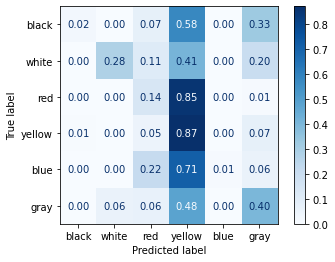

,model_arch,trained_on,acc_VERI,prec_VERI,f1_VERI,rec_VERI
0,resnet18,COMP_CARS,0.226021,0.662521,0.209333,0.226021


In [ ]:
model_archs = [
    "resnet18",
    # "resnet50",
    # "resnet152",
    # "mobilenetv3-small",
    # "efficientnet-b0",
    # "squeezenet",
]
train_dataset_names = [
    # ColorDatasets.VEHICLE_ID,
    ColorDatasets.COMP_CARS,
    # ColorDatasets.VERI,
    # ColorDatasets.COMBINED,
]
test_dataset_names = [
    # ColorDatasets.VEHICLE_ID,
    # ColorDatasets.COMP_CARS,
    ColorDatasets.VERI,
]
results = []
for model_arch in model_archs:
    for idx, train_dataset_name in enumerate(train_dataset_names):
        m_accs = []
        m_f1 = []
        m_prec = []
        m_rec = []

        for test_dataset_name in test_dataset_names:
            prediction_root, predict_model_name, best_model_path, prediction_out_file = get_conf_data(train_dataset_name, test_dataset_name, model_arch)
            accuracy_val, precision_val, f1_val, recall_val = evaluate_predictions(prediction_root, predict_model_name, best_model_path, 
                                prediction_out_file, test_dataset_name, allowed_color_list)

            m_accs.append(accuracy_val.item())
            m_prec.append(precision_val.item())
            m_f1.append(f1_val.item())
            m_rec.append(recall_val.item())

        results.append([model_arch, train_dataset_name.name]+ m_accs+m_prec+m_f1+m_rec)
        

columns = ['model_arch', 'trained_on']
for met in ['acc', 'prec', 'f1', 'rec']:
    for test_dataset_name in test_dataset_names:
        columns.append(f'{met}_{test_dataset_name.name}')
df = pd.DataFrame(results, columns=columns)

from IPython.display import display, HTML
display(HTML(df.to_html()))


---
## Observations
Do your analysis and notes here!

In [ ]:
!nvidia-smi

Fri Oct 15 20:32:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------